The code below fetches all the matches where either Union, Club Brugge or Cercle Brugge are present.

In [271]:
import pandas as pd
import psycopg2
import dotenv
import os

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

# Database connection parameters
import psycopg2
import os

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="require",
)

# Query to fetch match data
query = """
SELECT *
FROM matches
WHERE home_team_id IN ('1oyb7oym5nwzny8vxf03szd2h', '3ix9om1svhd6obl0mbk1otgop', 'ecj1gmc7pqcjo4sc9hvghj5u3')
   OR away_team_id IN ('1oyb7oym5nwzny8vxf03szd2h', '3ix9om1svhd6obl0mbk1otgop', 'ecj1gmc7pqcjo4sc9hvghj5u3')

"""
matches = pd.read_sql_query(query, conn)
matches.head()

,match_id,match_date,home_team_id,away_team_id,home_score,away_score
0,5oc8drrbruovbuiriyhdyiyok,2024-07-26,1oyb7oym5nwzny8vxf03szd2h,b7jmo07lqav0wfe2mtlzyspak,1,1
1,5ro450tmjg6o1r4cphzzyg74k,2024-07-28,2nhn3ikl1ciq34w3hcp883d6p,3ix9om1svhd6obl0mbk1otgop,3,0
2,5ow2wa823rjft38oh48b4ror8,2024-07-27,4dtif7outbuivua8umbwegoo5,ecj1gmc7pqcjo4sc9hvghj5u3,0,0
3,5u35bb21cuumrm2th8czyecr8,2024-08-04,3ix9om1svhd6obl0mbk1otgop,1uk609mhtsfhokhaewjapb26,1,2
4,5ugfsw7je1y0lay7xdqe3pces,2024-08-04,5z1b7fuvpqe6vnigvopomvecu,1oyb7oym5nwzny8vxf03szd2h,1,0


In [272]:
# Merged query to fetch event data with event type names
gameid = '6aaebu7uj50ewu3irl3qmjg2c'
teamid = '1oyb7oym5nwzny8vxf03szd2h'
query = """
SELECT *
FROM matchevents me
WHERE me.match_id = %s;
"""
events_df = pd.read_sql_query(query, conn, params=(gameid,))
events_df.head()

,match_id,event_id,eventtype_id,result,success,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,x,y,end_coordinates_x,end_coordinates_y,receiver_player_id
0,6aaebu7uj50ewu3irl3qmjg2c,2724177289,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,COMPLETE,True,1,0 days 00:00:00.013000,0 days 00:00:02.984000,alive,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,12zn29b1dqhexzrkvm43yuiac,50.4,50.2,36.0,39.6,32sds4yk7ch30mng0gyzhdk9h
1,6aaebu7uj50ewu3irl3qmjg2c,2724177375,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,INCOMPLETE,False,1,0 days 00:00:02.984000,NaT,alive,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,32sds4yk7ch30mng0gyzhdk9h,35.0,47.0,64.8,100.0,None
2,6aaebu7uj50ewu3irl3qmjg2c,2724177387,7f85b6d1-bb65-4fd8-8ff1-c3e584341a79,None,None,1,0 days 00:00:05.521000,NaT,dead,8y3iucyxguipljcmf87a11bk9,8y3iucyxguipljcmf87a11bk9,8kz0e83d3azssd7unbk2lqt0q,64.5,101.6,NaN,NaN,None
3,6aaebu7uj50ewu3irl3qmjg2c,2724177499,7f85b6d1-bb65-4fd8-8ff1-c3e584341a79,None,None,1,0 days 00:00:05.521000,NaT,dead,8y3iucyxguipljcmf87a11bk9,1oyb7oym5nwzny8vxf03szd2h,15odj8wui8136996wi2d5t7md,35.5,-1.6,NaN,NaN,None
4,6aaebu7uj50ewu3irl3qmjg2c,2724177531,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,COMPLETE,True,1,0 days 00:00:11.982000,0 days 00:00:15.763000,alive,1oyb7oym5nwzny8vxf03szd2h,1oyb7oym5nwzny8vxf03szd2h,9xvik8av83pfnqwwt85unf504,35.4,0.0,22.4,32.2,14yb6ab45h6z3lla1i3046f4k


In [273]:
# Retry the big query with a different schema
complex_query = """ 
SELECT *
FROM (
    SELECT 
        me.*, 
        et.name,
        LAG(me.ball_owning_team) OVER (
            PARTITION BY me.match_id 
            ORDER BY me.period_id, me.timestamp
        ) AS prev_ball_owning_team
    FROM matchevents me
    INNER JOIN eventtypes et ON me.eventtype_id = et.eventtype_id
    WHERE me.match_id = '6aaebu7uj50ewu3irl3qmjg2c'
) subquery
WHERE ball_owning_team <> prev_ball_owning_team
ORDER BY period_id, timestamp;
"""
# Execute the complex query
possession2_df = pd.read_sql_query(complex_query, conn)
print(f"Loaded {len(possession2_df)} possession-ending actions")
# Remove all actions which have a new action within 5 seconds make sure you only check in the same period_id


# Try converting 'timestamp' to timedelta if it's in duration format
try:
    possession2_df['timestamp'] = pd.to_timedelta(possession2_df['timestamp'])
except Exception as e:
    print(f"Error converting timestamp: {e}")

# Sort by period_id and timestamp to ensure we have the events in chronological order
possession2_df = possession2_df.sort_values(by=['period_id', 'timestamp'])

# Add columns for the previous and next timestamps within the same period_id
possession2_df['prev_timestamp'] = possession2_df.groupby('period_id')['timestamp'].shift(1)
possession2_df['next_timestamp'] = possession2_df.groupby('period_id')['timestamp'].shift(-1)

# Filter out the actions that have another action within 5 seconds before or after it
mask = (
    ((possession2_df['timestamp'] - possession2_df['prev_timestamp']).abs().dt.total_seconds() > 5) & 
    ((possession2_df['next_timestamp'] - possession2_df['timestamp']).abs().dt.total_seconds() > 5)
)

# Apply the mask to filter the dataframe
filtered_possession2_df = possession2_df[mask]

print(f"Filtered down to {len(filtered_possession2_df)} possession-ending actions")

# Now add a time_seconds column to the filtered dataframe based on the timestamp
filtered_possession2_df = filtered_possession2_df.copy()  # Ensure it's a separate copy
filtered_possession2_df.loc[:, 'time_seconds'] = filtered_possession2_df['timestamp'].dt.total_seconds()


Loaded 239 possession-ending actions
Filtered down to 108 possession-ending actions


In [274]:
# Get all the player tracking data for "gameid"
query = """
select *
from player_tracking
where game_id = %s
"""
player_tracking_df = pd.read_sql_query(query, conn, params=(gameid,))
print(f"Loaded {len(player_tracking_df)} player tracking data")
# Add the time_seconds column to the player_tracking_df based on the timestamp
# Convert timestamp to timedelta
player_tracking_df['timestamp'] = pd.to_timedelta(player_tracking_df['timestamp'])

# Extract total seconds
player_tracking_df['time_seconds'] = player_tracking_df['timestamp'].dt.total_seconds()

display(player_tracking_df.head())




Loaded 138851 player tracking data


,id,game_id,frame_id,timestamp,period_id,player_id,x,y,time_seconds
0,7407205,6aaebu7uj50ewu3irl3qmjg2c,1727012147000,0 days 00:05:47,1,7eox5w91a19w4kx2u3cc8d4yy,57.534426,21.142818,347.0
1,7407206,6aaebu7uj50ewu3irl3qmjg2c,1727012147000,0 days 00:05:47,1,bybggxgpzlr7xz2f1i3b7c0kp,79.852438,27.738245,347.0
2,7407207,6aaebu7uj50ewu3irl3qmjg2c,1727012147000,0 days 00:05:47,1,15odj8wui8136996wi2d5t7md,74.458879,35.529727,347.0
3,7407208,6aaebu7uj50ewu3irl3qmjg2c,1727012147000,0 days 00:05:47,1,be0ws51ws5cm9wzmcp3ozmklx,94.878073,44.104945,347.0
4,7407209,6aaebu7uj50ewu3irl3qmjg2c,1727012148000,0 days 00:05:48,1,ball,79.953973,27.579818,348.0


In [275]:
# Get all the player info for "teamid"
query = """
select *
from players
where team_id = %s
and player_name != 'Ball' 
"""
players_df = pd.read_sql_query(query, conn, params=(teamid,))
print(f"Loaded {len(players_df)} players data")
display(players_df.head())

Loaded 26 players data


,player_id,player_name,team_id,jersey_number
0,byfrgpc6tgz8lto1gor03y5sl,S. Mignolet,1oyb7oym5nwzny8vxf03szd2h,22
1,9xvik8av83pfnqwwt85unf504,J. Seys,1oyb7oym5nwzny8vxf03szd2h,65
2,buglwgk2hthoyqt1ocghya92i,Z. Romero,1oyb7oym5nwzny8vxf03szd2h,2
3,l6y4o9t2b0jxaxo85oztok45,B. Mechele,1oyb7oym5nwzny8vxf03szd2h,44
4,bjhjz96omjukrg6tj3mny39t6,M. De Cuyper,1oyb7oym5nwzny8vxf03szd2h,55


In [276]:
# Get all the ball positions for the match
query = """ 
select *
from player_tracking
where player_id = 'ball' and game_id = %s
order by frame_id, timestamp
"""
ball_position_df = pd.read_sql_query(query, conn, params=(gameid,))
#Add an extra column time_seconds to the ball_position_df based on the timestamp
ball_position_df['timestamp'] = pd.to_timedelta(ball_position_df['timestamp'])
# Extract total seconds
ball_position_df['time_seconds'] = ball_position_df['timestamp'].dt.total_seconds()
print(f"Loaded {len(ball_position_df)} ball positions")
display(ball_position_df.head())

Loaded 6037 ball positions


,id,game_id,frame_id,timestamp,period_id,player_id,x,y,time_seconds
0,7399205,6aaebu7uj50ewu3irl3qmjg2c,1727011800000,0 days 00:00:00,1,ball,50.245902,50.222951,0.0
1,7399228,6aaebu7uj50ewu3irl3qmjg2c,1727011801000,0 days 00:00:01,1,ball,64.434138,51.796721,1.0
2,7399251,6aaebu7uj50ewu3irl3qmjg2c,1727011802000,0 days 00:00:02,1,ball,65.419741,52.622951,2.0
3,7399274,6aaebu7uj50ewu3irl3qmjg2c,1727011803000,0 days 00:00:03,1,ball,62.906897,50.734426,3.0
4,7399297,6aaebu7uj50ewu3irl3qmjg2c,1727011804000,0 days 00:00:04,1,ball,52.104918,31.319273,4.0


In [280]:
#Only keep the first 5 rows of the filtered_df dataframe
filtered_possession2_df = filtered_possession2_df.head(2)
display(filtered_possession2_df)


,match_id,event_id,eventtype_id,result,success,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,...,x,y,end_coordinates_x,end_coordinates_y,receiver_player_id,name,prev_ball_owning_team,prev_timestamp,next_timestamp,time_seconds
1,6aaebu7uj50ewu3irl3qmjg2c,2724178299,127294ef-9a42-4599-a128-e9b35d90bfbc,None,None,1,0 days 00:00:56.812000,NaT,alive,8y3iucyxguipljcmf87a11bk9,...,39.8,80.1,NaN,NaN,None,GENERIC:ball touch,1oyb7oym5nwzny8vxf03szd2h,0 days 00:00:11.982000,0 days 00:01:02.592000,56.812
2,6aaebu7uj50ewu3irl3qmjg2c,2724178361,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,COMPLETE,True,1,0 days 00:01:02.592000,0 days 00:01:08.432000,alive,1oyb7oym5nwzny8vxf03szd2h,...,59.9,0.0,35.2,27.3,14yb6ab45h6z3lla1i3046f4k,PASS,8y3iucyxguipljcmf87a11bk9,0 days 00:00:56.812000,0 days 00:01:24.214000,62.592


In [278]:
# For the match find out whether team_id starts left or right
# This can be checked by looking at all the player positions at the start of the match timestamp 00:00:00
# The dataframes which are used are player_tracking_df and players_df
player_start_positions= player_tracking_df[player_tracking_df['time_seconds'] == 0]
# Only keep the players which are in the players_df dataframe
player_start_positions = player_start_positions[player_start_positions['player_id'].isin(players_df['player_id'])]
# Get the x and y positions of the players
player_start_positions = player_start_positions[['x', 'y', 'player_id']]
# Now calculate the average x and y positions of the players
player_start_positions['x'] = player_start_positions['x'].astype(float)
# Calculate the average x position of the players
average_x = player_start_positions['x'].mean()
started_left = average_x < 50
print(f"Average x position of players: {average_x} - started left: {started_left}")

Average x position of players: 35.30442525800167 - started left: True


Now plot all these actions on the field.

1 56.812 GENERIC:ball touch
1 62.592 PASS


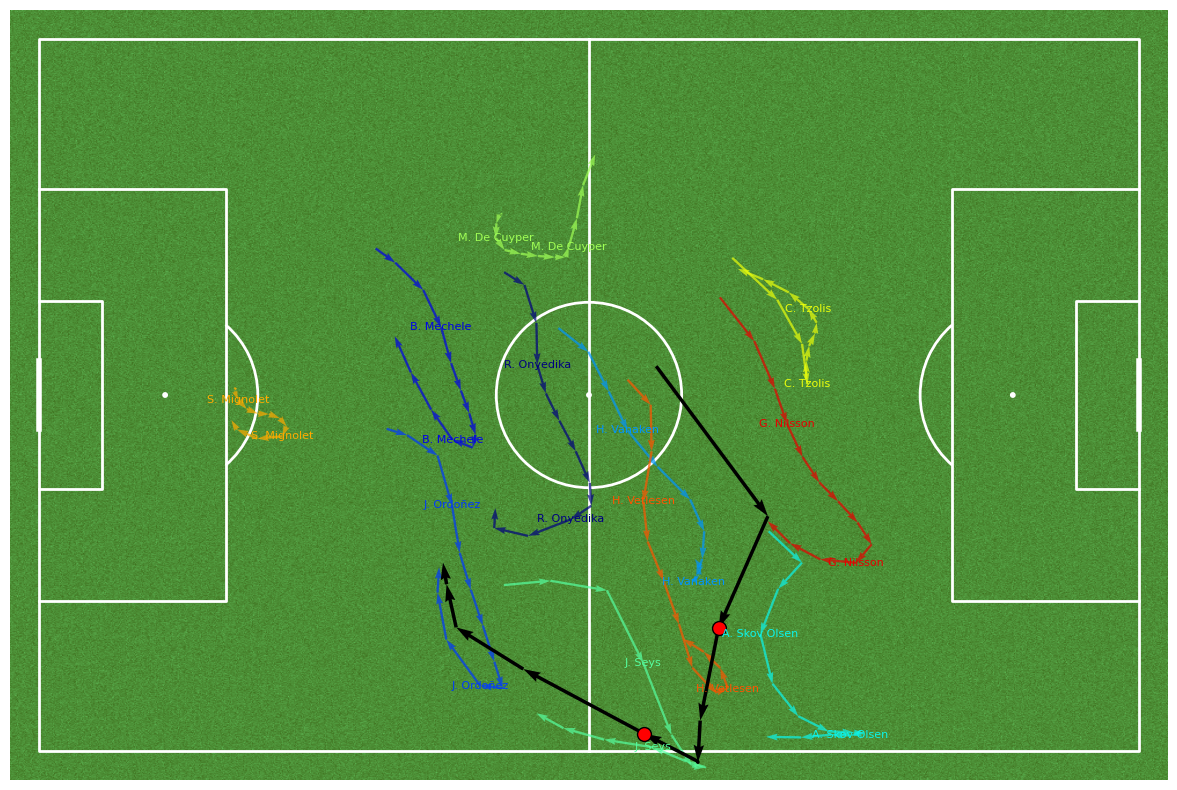

In [281]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Set up the pitch
pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta')  
fig, ax = pitch.draw(figsize=(12, 8))

pitch_width = 105  # Opta pitch width
pitch_length = 68  # Opta pitch length

def maybe_flip_x(x_values, period_id):
   # Flip x-coordinates if the condition is met.
    if (started_left and period_id == 2) or (not started_left and period_id == 1):
        return pitch_width - x_values
    return x_values
def maybe_flip_y(y_values, period_id):
    # Flip y-coordinates if the condition is met.
    if (started_left and period_id == 2) or (not started_left and period_id == 1):
        return pitch_length - y_values
    return y_values

# Generate unique colors for each ball position
num_actions = len(filtered_possession2_df)
colors = cm.viridis(np.linspace(0, 1, num_actions))

for i, (_, row) in enumerate(filtered_possession2_df.iterrows()):
    print(row['period_id'], row['time_seconds'], row['name'])
    row_time = row['time_seconds']
    period_id = row['period_id']
    
    # Get ball positions
    ball_data = ball_position_df[
        (ball_position_df['time_seconds'] >= row_time - 2) & 
        (ball_position_df['time_seconds'] <= row_time + 5) & 
        (ball_position_df['period_id'] == period_id)
    ]
    
    if len(ball_data) > 1:
        x_positions = maybe_flip_x(ball_data['x'].values, period_id)
        y_positions = maybe_flip_y(ball_data['y'].values, period_id)
        dx = np.diff(x_positions)
        dy = np.diff(y_positions)

        ax.quiver(x_positions[:-1], y_positions[:-1], dx, dy, angles='xy', scale_units='xy', 
                  scale=1, color="black", zorder=4, width=0.003)
        ax.scatter(x_positions[np.abs(ball_data['time_seconds'] - row_time).argmin()], 
                   y_positions[np.abs(ball_data['time_seconds'] - row_time).argmin()], 
                   color='red', s=100, edgecolor='black', zorder=5)
    
    # Get player positions
    player_data = player_tracking_df[
        (player_tracking_df['time_seconds'] >= row_time - 2) & 
        (player_tracking_df['time_seconds'] <= row_time + 5) & 
        (player_tracking_df['period_id'] == period_id)
    ]
    
    player_ids = player_data['player_id'].unique()
    player_ids = [pid for pid in player_ids if pid in players_df['player_id'].values]
    player_colors = {pid: cm.jet(i / len(player_ids)) for i, pid in enumerate(player_ids)}
    
    for player_id in player_ids:
        player_positions = player_data[player_data['player_id'] == player_id]
        if len(player_positions) > 1:
            x_positions = maybe_flip_x(player_positions['x'].values, period_id)
            y_positions = maybe_flip_y(player_positions['y'].values, period_id)
            dx = np.diff(x_positions)
            dy = np.diff(y_positions)

            ax.quiver(x_positions[:-1], y_positions[:-1], dx, dy, angles='xy', scale_units='xy', 
                      scale=1, color=player_colors[player_id], zorder=3, width=0.002, alpha=0.7)
            mid_index = len(x_positions) // 2
            ax.text(x_positions[mid_index], y_positions[mid_index], 
                    f'{players_df[players_df["player_id"] == player_id]["player_name"].values[0]}',
                    color=player_colors[player_id], fontsize=8, ha='center', va='center', zorder=5)

plt.show()